The purpose of this notebook is to compute the FIM of an NN potential for C with respect to the  weights and biases corresponding to the mapping from the last hidden layer to the output layer.
It is similar to what's in `fim_last_layer.ipynb`, but in this notebook we add the prior term when computing the FIM.
Since we add a prior, then this method is more Bayesian.

In [1]:
from pathlib import Path
import json
import sys
from tqdm import tqdm
import subprocess
from multiprocessing import Pool


import numpy as np
import scipy
import matplotlib.pyplot as plt
import numdifftools as nd
import torch

from kliff import nn
from kliff.calculators import CalculatorTorch
from kliff.dataset import Dataset
from kliff.dataset.weight import Weight
from kliff.descriptors import SymmetryFunction
from kliff.models import NeuralNetwork

# Random seed
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
# torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib inline
plt.style.use("default")

# Setup

## Variables

In [2]:
# Read setting file
WORK_DIR = Path().absolute()
ROOT_DIR = WORK_DIR.parent
DATA_DIR = ROOT_DIR / "data"
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
suffix = "_".join([str(n) for n in settings["Nnodes"]])
PART_DIR = DATA_DIR / f"{partition}_partition_data"
FP_DIR = PART_DIR / "fingerprints"
RES_DIR = WORK_DIR / "results" / f"{partition}_partition_{suffix}"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

## Model

In [3]:
# Architecture
Nlayers = settings["Nlayers"]  # Number of layers, excluding input layer, including outpt layer
Nnodes = settings["Nnodes"]  # Number of nodes per hidden layer
dropout_ratio = 0.0  # Don't use dropout

# Optimizer settings
learning_rate = 1e-3
batch_size = 100
nepochs_total = 40_000  # How many epochs to run in total
nepochs_initial = 2000  # Run this many epochs first
nepochs_save_period = 10  # Then run and save every this many epochs
epoch_change_lr = 5000  # This is the epoch when we change the learning rate

In [4]:
# Descriptor
descriptor = SymmetryFunction(
    cut_name="cos", cut_dists={"C-C": 5.0}, hyperparams="set51", normalize=True
)
model = NeuralNetwork(descriptor)

# Layers
hidden_layer_mappings = []
for ii in range(Nlayers - 2):
    hidden_layer_mappings.append(nn.Dropout(dropout_ratio))
    hidden_layer_mappings.append(nn.Linear(Nnodes[ii], Nnodes[ii + 1]))
    hidden_layer_mappings.append(nn.Tanh())

model.add_layers(
    # input layer
    nn.Linear(descriptor.get_size(), Nnodes[0]),  # Mapping from input layer to the first
    nn.Tanh(),  # hidden layer
    # hidden layer(s)
    *hidden_layer_mappings,  # Mappings between hidden layers in the middle
    # hidden layer(s)
    nn.Dropout(dropout_ratio),  # Mapping from the last hidden layer to the output layer
    nn.Linear(Nnodes[-1], 1),
    # output layer
)

# Load best model
orig_model_path = (
    ROOT_DIR
    / "training_dropout"
    / "results"
    / "training"
    / f"{partition}_partition_{suffix}"
    / "model_best_train.pkl"
)
model.load(orig_model_path)

2024-05-16 14:32:41.405 | INFO     | kliff.models.model_torch:load:117 - Model loaded from `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/training_dropout/results/training/mingjian_partition_128_128_128/model_best_train.pkl`


## Training set and calculator

In [5]:
# training set
dataset_path = PART_DIR / "carbon_training_set"
weight = Weight(energy_weight=1.0, forces_weight=np.sqrt(0.1))
tset = Dataset(dataset_path, weight)
configs = tset.get_configs()
nconfigs = len(configs)

# calculator
gpu = False
calc = CalculatorTorch(model, gpu=gpu)
_ = calc.create(
    configs,
    nprocs=20,
    reuse=True,
    fingerprints_filename=FP_DIR / f"fingerprints_train.pkl",
    fingerprints_mean_stdev_filename=FP_DIR / f"fingerprints_train_mean_and_stdev.pkl",
)
bestfit_params = calc.get_opt_params()

2024-05-16 14:32:45.292 | INFO     | kliff.dataset.dataset:_read:398 - 4344 configurations read from /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/data/mingjian_partition_data/carbon_training_set
2024-05-16 14:32:45.307 | INFO     | kliff.calculators.calculator_torch:_get_device:592 - Training on cpu
2024-05-16 14:32:45.313 | INFO     | kliff.calculators.calculator_torch:create:93 - Reuse fingerprints `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/data/mingjian_partition_data/fingerprints/fingerprints_train.pkl`
2024-05-16 14:32:45.317 | INFO     | kliff.calculators.calculator_torch:create:111 - Reuse fingerprints mean and stdev `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/data/mingjian_partition_data/fingerprints/fingerprints_train_mean_and_stdev.pkl`


# Real calculation

In [6]:
device = model.device
loader = calc.get_compute_arguments(batch_size)
layers_no_output = model.layers[:-1]

## Get reference data

4344


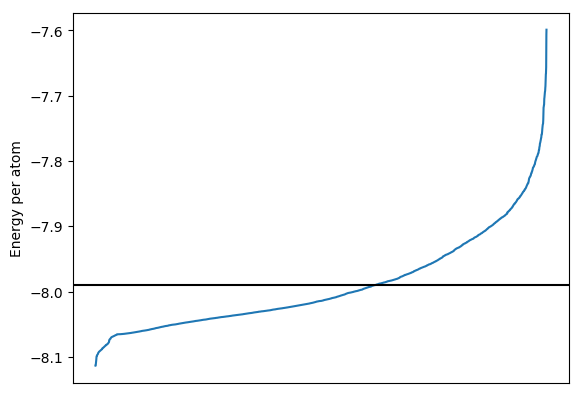

In [7]:
reference_energy = []
energy_natoms = []
for batch in loader:
    batch_energy = np.array([float(sample["energy"]) for sample in batch])
    batch_natoms = np.array([sample["forces"].shape[0] for sample in batch])
    reference_energy = np.append(reference_energy, batch_energy)
    energy_natoms = np.append(energy_natoms, batch_natoms)
print(len(reference_energy))

plt.figure()
plt.plot(np.sort(reference_energy / energy_natoms))
plt.axhline(np.mean(reference_energy / energy_natoms), color="k")
plt.xticks([])
plt.ylabel("Energy per atom")
plt.show()

(619746,)


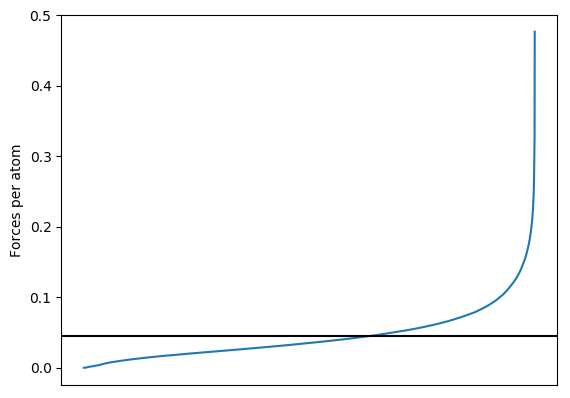

In [8]:
reference_forces = []
forces_natoms = []
for batch in loader:
    batch_forces = [sample["forces"].numpy().flatten() for sample in batch]
    batch_natoms = [
        np.repeat(sample["forces"].shape[0], np.prod(sample["forces"].shape))
        for sample in batch
    ]
    reference_forces = np.append(reference_forces, np.concatenate(batch_forces))
    forces_natoms = np.append(forces_natoms, np.concatenate(batch_natoms))
print(reference_forces.shape)

reference_forces_reshaped = reference_forces.reshape((-1, 3))
reference_forces_mag = np.linalg.norm(reference_forces_reshaped, axis=1)
reference_forces_mag = np.repeat(reference_forces_mag, 3)
plt.figure()
plt.plot(np.sort(reference_forces_mag / forces_natoms))
plt.axhline(np.mean(reference_forces_mag / forces_natoms), color="k")
plt.xticks([])
plt.ylabel("Forces per atom")
plt.show()

## Compute the Jacobian

In [9]:
# Compute the derivative of the energy
de_file = Path(RES_DIR / "jacobian_energy.npy")

if de_file.exists():
    de_all = np.load(de_file)
else:
    de_all = np.empty((0, 129))  # There are 128 weights and 1 bias

    for batch in tqdm(loader):
        # batch = next(iter(loader))

        # Get the fingerprints - these lines are from calc.compute
        zeta_config = [sample["zeta"] for sample in batch]  # Zeta for each config
        zeta_stacked = torch.cat(zeta_config, dim=0).to(device)
        zeta_stacked.requires_grad_(True)
        natoms_config = [len(zeta) for zeta in zeta_config]  # Number of atoms per config

        # Try to retrieve values from the last hidden layer
        x_atom = torch.clone(zeta_stacked)
        for layer in layers_no_output:
            x_atom = layer(x_atom)

        x_config = [e.sum(0) for e in torch.split(x_atom, natoms_config)]
        # Derivative of the energy with respect to the weights
        de = np.array([elem.detach().numpy() for elem in x_config])
        # Add the derivative of energy with respect to the bias
        de = np.column_stack((de, np.ones(len(de))))

        # Append to the container matrix
        de_all = np.row_stack((de_all, de))

    # Export
    np.save(RES_DIR / "jacobian_energy.npy", de_all)

In [10]:
# Compute the derivative of the energy
df_file = Path(RES_DIR / "jacobian_forces.npy")

# Unlike the calculation for the derivative of the energy, this calculation took me
# about 5 minutes. Just loading the data even took about 5s.
if df_file.exists():
    df_all = np.load(df_file)
else:
    df_all = np.empty((0, 129))  # There are 128 weights and 1 bias

    for batch in tqdm(loader):
        # batch = next(iter(loader))

        # Get the fingerprints - these lines are from calc.compute
        zeta_config = [sample["zeta"] for sample in batch]  # Zeta for each config
        zeta_stacked = torch.cat(zeta_config, dim=0).to(device)
        zeta_stacked.requires_grad_(True)
        natoms_config = [len(zeta) for zeta in zeta_config]  # Number of atoms per config

        # Try to retrieve values from the last hidden layer
        x_atom = torch.clone(zeta_stacked)
        for layer in layers_no_output:
            x_atom = layer(x_atom)

        x_config = [e.sum(0) for e in torch.split(x_atom, natoms_config)]
        # Derivative of the energy with respect to the weights
        de = np.array([elem.detach().numpy() for elem in x_config])
        # Add the derivative of energy with respect to the bias
        de = np.column_stack((de, np.ones(len(de))))

        # Derivative of the forces with respect to all weights of the last hidden layer
        df = []
        for x_atom_node in x_atom.T:
            # de/dzeta for the  first node of the last hidden layer
            x_atom_node = x_atom_node.reshape((-1, 1))
            dedzeta = torch.autograd.grad(
                x_atom_node.sum(), zeta_stacked, create_graph=True
            )[0]
            dedzeta_config = torch.split(dedzeta, natoms_config)

            # df/dzeta for the first node of the last hidden layer
            forces_config = []
            for i, sample in enumerate(batch):
                dedz = dedzeta_config[i]

                dzetadr_forces = sample["dzetadr_forces"].to(device)
                f = calc._compute_forces(dedz, dzetadr_forces)
                forces_config.append(f)
            forces_config = torch.cat(forces_config)
            df.append(forces_config)

        # Stack the forces
        df = torch.stack(df).T
        zeta_stacked.requires_grad_(False)

        # Convert to numpy
        df = df.detach().numpy()
        # Add the derivative with respect to the bias
        df = np.column_stack((df, np.zeros(len(df))))

        # Append to the container matrix
        df_all = np.row_stack((df_all, df))

    # Export
    np.save(df_file, df_all)

## Compute the FIM

Derivation of the FIM with using the posterior
* Posterior
    \begin{align*}
        P(\theta | y) &= \frac{L(\theta | y) \pi(\theta)}{P(y)} \\
        L(\theta | y) &= \frac{1}{N_L} \exp{\left[ -\frac{1}{2} \sum_m \left( \frac{y_m - f_m(\theta)}{\sigma_m} \right)^2 \right]} \\
        \pi(\theta) &= \frac{1}{N_\pi} \exp{\left[ -\frac{1}{2} \sum_n \left( \frac{\theta_n - \theta_n^*}{s_n} \right)^2 \right]}
    \end{align*}

* Log-posterior
    \begin{equation*}
        \log [P(\theta | y)] = \log [L(\theta | y)] + \log [\pi(\theta)] - \log [P(y)]
    \end{equation*}
    
* Hessian of log-posterior
    \begin{equation*}
        \frac{\partial^2 \log [P(\theta | y)]}{\partial \theta_\mu \partial \theta_\nu} = \frac{\partial^2 \log [L(\theta | y)]}{\partial \theta_\mu \partial \theta_\nu} + \frac{\partial^2 \log [\pi(\theta)]}{\partial \theta_\mu \partial \theta_\nu}
    \end{equation*}
    $P(y)$ is independent of $\theta$.
    
    * Hessian of log-likelihood
        \begin{align*}
            \log [L(\theta | y)] &= -\log(N_L) -\frac{1}{2} \sum_m \left( \frac{y_m - f_m(\theta)}{\sigma_m} \right)^2 \\
            \frac{\partial \log [L(\theta | y)]}{\partial \theta_\mu} &= \sum_m \left( \frac{y_m - f_m(\theta)}{\sigma_m^2} \right) \left( \frac{\partial f_m(\theta)}{\partial \theta_\mu} \right) \\
            \frac{\partial^2 \log [L(\theta | y)]}{\partial \theta_\mu \partial \theta_\nu} &= \sum_m \left[ -\frac{1}{\sigma_m^2} \frac{\partial f_m(\theta)}{\partial \theta_\mu} \frac{\partial f_m(\theta)}{\partial \theta_\nu} + \left( \frac{y_m - f_m(\theta)}{\sigma_m^2} \right) \frac{\partial^2 f_m(\theta)}{\partial \theta_\mu \partial \theta_\nu} \right]
        \end{align*}

    * Hessian of log-prior
        \begin{align*}
            \log [\pi(\theta)] &= \log(N_\pi) -\frac{1}{2} \sum_n \left( \frac{\theta_n - \theta_n^*}{s_n} \right)^2 \\
            \frac{\partial \log [\pi(\theta)]}{\partial \theta_\mu} &= -\left( \frac{\theta_\mu - \theta_\mu^*}{s_\mu^2} \right) \\
            \frac{\partial^2 \log [\pi(\theta)]}{\partial \theta_\mu \partial \theta_\nu} &= - \frac{\delta_{\mu \nu}}{s_\mu^2}
        \end{align*}
        
* Negative expectation value of the Hessian - FIM
    \begin{align*}
        -\left< \frac{\partial^2 \log [P(\theta | y)]}{\partial \theta_\mu \partial \theta_\nu} \right> &= -\left< \frac{\partial^2 \log [L(\theta | y)]}{\partial \theta_\mu \partial \theta_\nu} \right> - \left< \frac{\partial^2 \log [\pi(\theta)]}{\partial \theta_\mu \partial \theta_\nu} \right> \\
        &= \sum_m \left[ \frac{1}{\sigma_m^2} \frac{\partial f_m(\theta)}{\partial \theta_\mu} \frac{\partial f_m(\theta)}{\partial \theta_\nu} \right] + \frac{\delta_{\mu \nu}}{s_\mu^2}
    \end{align*}

In [11]:
# Log-likelihood term
fim_energy = de_all.T @ de_all
fim_forces = 0.1 * df_all.T @ df_all  # The forces are weighted by sqrt(0.1)
fim_like = fim_energy + fim_forces

# Log-prior term
fan_in = model.layers[-1].in_features
fan_out = model.layers[-1].out_features
s = np.sqrt(2 / (fan_in + fan_out))  # standard deviation of the Gaussian prior
fim_prior = np.diag(np.ones(len(fim_like)) / (s ** 2))

# FIM using posterior
fim_configs = fim_like + fim_prior

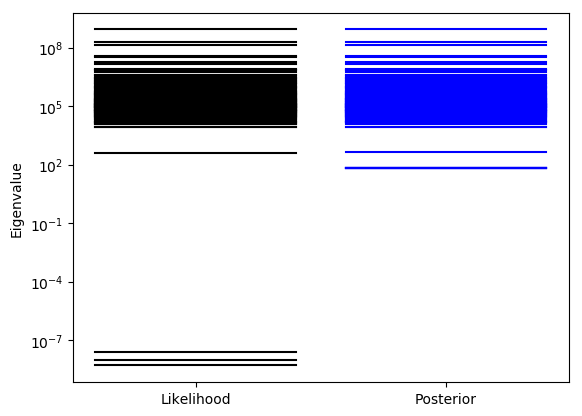

In [12]:
# Eigenvalues
eigvals_like = scipy.linalg.eigvalsh(fim_like)
eigvals_post = scipy.linalg.eigvalsh(fim_configs)
# print(eigvals)

plt.figure()
for lam1, lam2 in zip(eigvals_like, eigvals_post):
    plt.plot([-0.4, 0.4], [lam1, lam1], c="k")
    plt.plot([0.6, 1.4], [lam2, lam2], c="b")
plt.yscale("log")
plt.xticks([0, 1], ["Likelihood", "Posterior"])
plt.ylabel("Eigenvalue")
plt.show()

# Model Ensemble

In [13]:
# Covariance
cov = scipy.linalg.pinvh(fim_configs)
np.save(RES_DIR / "covariance_parameters.npy", cov)
# scipy.linalg.eigvalsh(cov)

In [14]:
# Parameter samples
nparams = 129
p0 = bestfit_params[-nparams:]

param_samples_file = RES_DIR / "samples_bayes_parameters.npy"
if param_samples_file.exists():
    param_samples = np.load(param_samples_file)
else:
    param_samples = np.random.multivariate_normal(p0, cov, 100)
    np.save(param_samples_file, param_samples)

In [15]:
# def install_uninstall_model(modelname, mode="install"):
#     """This function will install or remove KIM model."""
#     kim_command = "kim-api-collections-management"
#     if mode == "install":
#         flags = ["install", "user"]
#     elif mode == "uninstall":
#         flags = ["remove", "--force"]
#         modelname = Path(modelname).name
#     command = np.concatenate(([kim_command], flags, [modelname]))
#     subprocess.run(command)

In [16]:
# # Write and install model ensembles
# for ii, params in tqdm(enumerate(param_samples), total=len(param_samples)):
#     # Write the model
#     complete_params = bestfit_params.copy()
#     complete_params[-nparams:] = params
#     calc.update_model_params(complete_params)  # Update parameters
#     # Install model
#     modelpath = RES_DIR / f"{ii:03d}" / f"DUNN_C_fimbayes_{ii:03d}"
#     model.write_kim_model(modelpath)  # Write

In [17]:
# def install_uninstall_wrapper(ii):
#     modelname = RES_DIR / f"{ii:03d}" / f"DUNN_C_fimbayes_{ii:03d}"
#     install_uninstall_model(modelname, "install")


# with Pool(25) as p:
#     p.map(install_uninstall_wrapper, range(100))